In [59]:
#libraries
import pandas as pd
from plotnine import ggplot, aes, geom_bar, facet_wrap, theme, element_text, labs, geom_col, geom_point, geom_density, coord_flip, theme_minimal, geom_boxplot, scale_fill_manual, geom_line, geom_smooth
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

**Part One: Data Exploration**

1. Read in the dataset, and display some summaries of the data.

2. Fix any concerns you have about the data.

3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

**#1**

In [2]:
#data
insurance = pd.read_csv('data/insurance_costs_1.csv')

In [3]:
#data summary 1
#using describe
insurance.describe(include = 'all')

,age,sex,bmi,smoker,region,charges
count,431.000000,431,431.000000,431,431,431.000000
unique,NaN,2,NaN,2,4,NaN
top,NaN,female,NaN,no,southeast,NaN
freq,NaN,225,NaN,344,125,NaN
mean,37.960557,NaN,30.768898,NaN,NaN,12297.098118
std,16.363909,NaN,6.111362,NaN,NaN,11876.527128
min,18.000000,NaN,15.960000,NaN,NaN,1131.506600
25%,22.000000,NaN,26.357500,NaN,NaN,2710.444575
50%,34.000000,NaN,30.590000,NaN,NaN,9866.304850
75%,55.000000,NaN,35.272500,NaN,NaN,14510.872600


In [4]:
#data summary 2
#average charge for these 4 groups using crosstab
pd.crosstab(insurance['smoker'], insurance['sex'], values=insurance['charges'], aggfunc='mean')


sex,female,male
smoker,,
no,7612.705697,7431.593879
yes,31246.856420,31068.158843


**#2**

In [5]:
#fix data
#i dont see anything wrong with the data? maybe just removing NA's
na_counts = insurance.isna().sum()
print(na_counts)

#no NA's so not an issue

age        0
sex        0
bmi        0
smoker     0
region     0
charges    0
dtype: int64
age        0
sex        0
bmi        0
smoker     0
region     0
charges    0
dtype: int64


**#3**

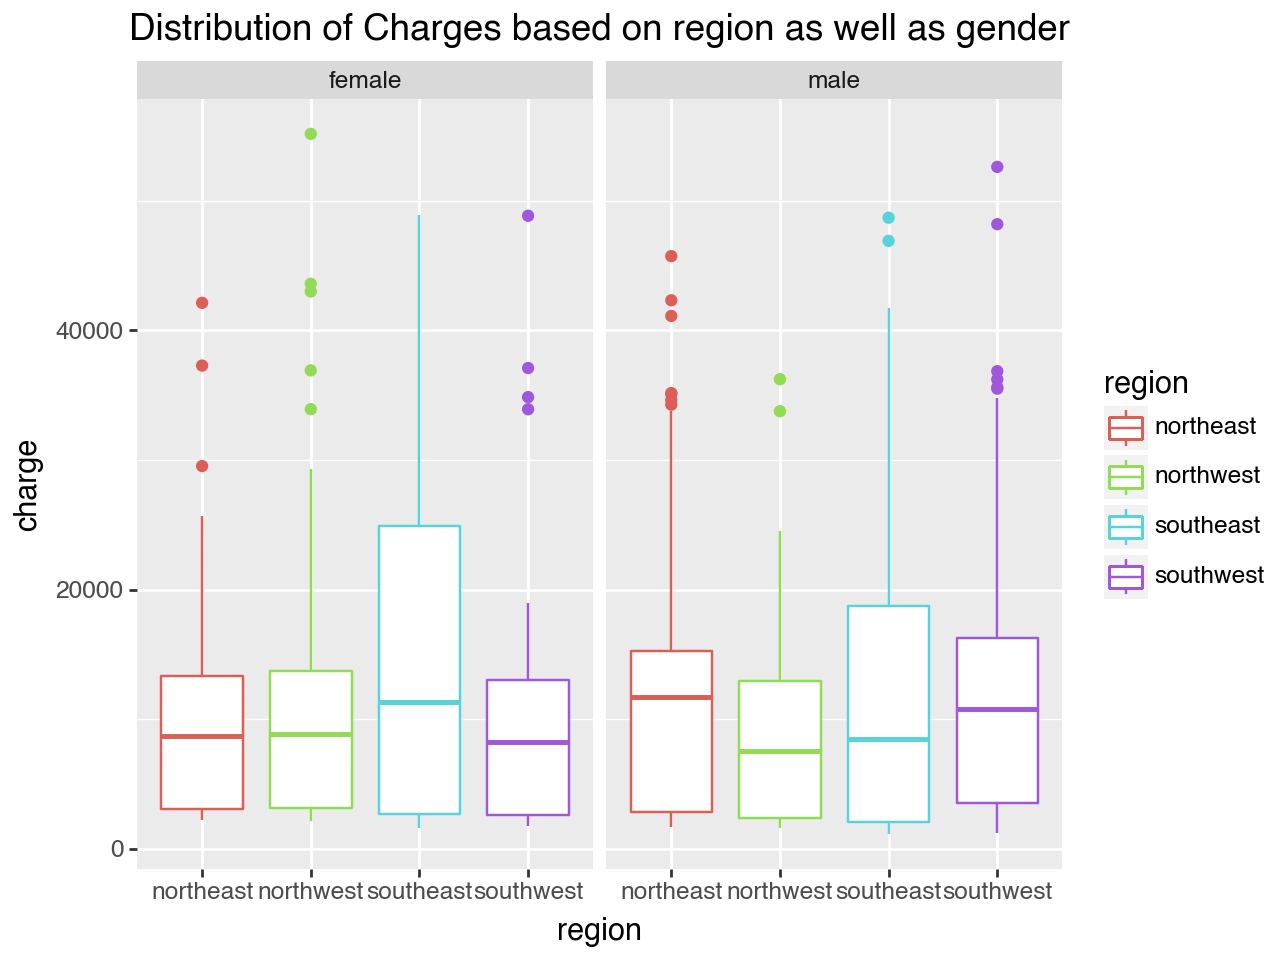

In [6]:
#graphical summary 1
(ggplot(insurance, aes(x = 'region', y = 'charges', color = 'region'))
+ geom_boxplot()
+ facet_wrap('sex')
+ labs(title='Distribution of Charges based on region as well as gender', x='region', y='charge')
)

We can see that when comparing charge by region and sex. There are typically higher charges for females compared to males in the southeast region. Additionally, there are typically lower charges for females compared to males in the southeast region.

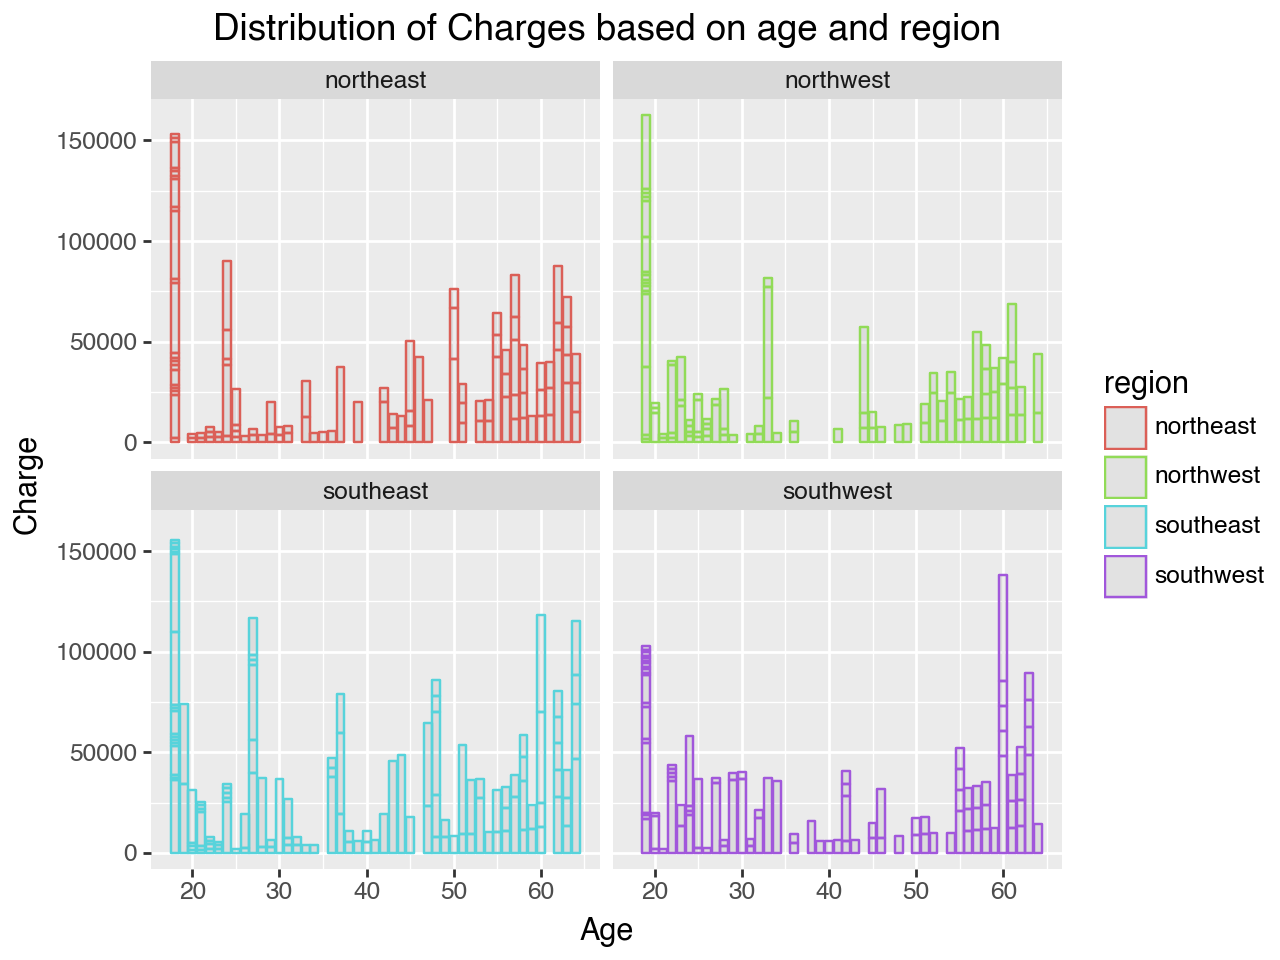

In [7]:
#graphical summary 2
(ggplot(insurance, aes(x='age', y='charges', color = 'region'))
    #fill to show proportions
    + geom_col(alpha = .1) 
    #wraps for geography
    + facet_wrap('region')
    + labs(title='Distribution of Charges based on age and region', x='Age', y='Charge')
)


From this graph we can see that charges tend to be higher for higher aged individuals in the southwest and southeast region. Additionally, for basically all the regions, the lowest charge tends to be where the center of the age variable is (around 35-55). This can be either because the charge is less severe or because there are overall less charges aswell.

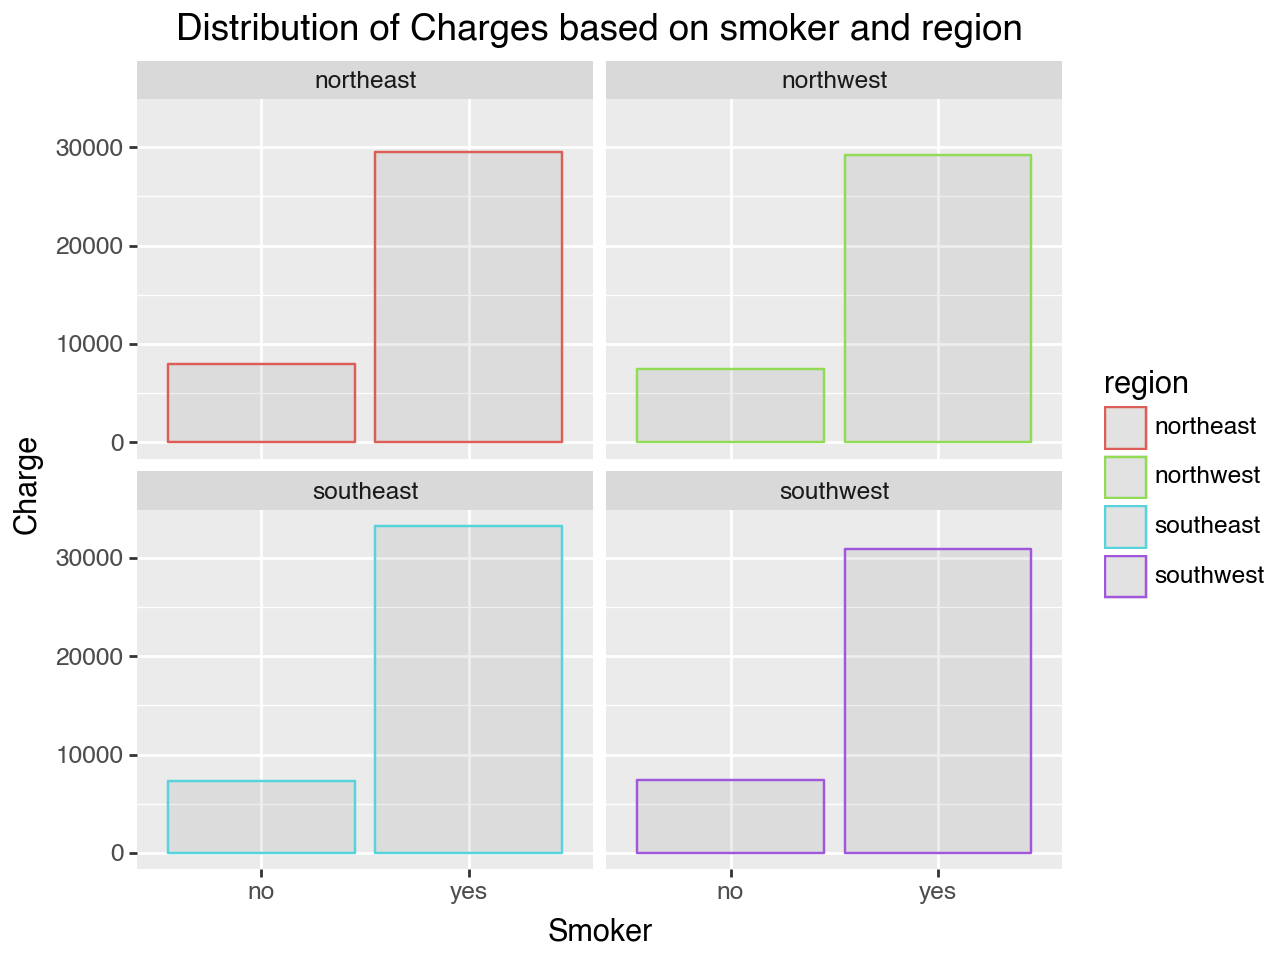

In [8]:
#graphical summary 2
(ggplot(insurance, aes(x='smoker', y='charges', color = 'region'))
    #fill to show proportions
    + geom_col(stat = 'summary', fun_y = np.mean, alpha = .1) 
    #wraps for geography
    + facet_wrap('region')
    + labs(title='Distribution of Charges based on smoker and region', x='Smoker', y='Charge')
)

From this graph, after using the average of each group, we can see that it is quite apparent that whether or not someone smoke made the charge on average way higher. Overall all the regions follow the same pattern with smoker beind significantly higher than a nonsmoker (this effect is greatest shown in the southeast region)

**Part Two: Simple Linear Models**

1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

2. Make a model that also incorporates the variable sex. Report your results.

3. Now make a model that does not include sex, but does include smoker. Report your results.

4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

**#1**

In [9]:
#model to predict charge from age

#pick only charge and age
X = insurance[["age"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [10]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coeff
print("age coeff: ", lr_pipeline_1.named_steps["linear_regression"].coef_)
#intercept
print("intercept: ", lr_pipeline_1.named_steps["linear_regression"].intercept_)


#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)


age coeff:  [3739.70080761]
intercept:  12297.098118187932
r2:  0.08852044938114441  mse:  127329756.22548977
age coeff:  [3739.70080761]
intercept:  12297.098118187932
r2:  0.08852044938114441  mse:  127329756.22548977


The model fit did not seem to do very well as the R^2 we got from it was .088 (which is really small) and an MSE of 127329756.22 (really big)

We get a coeff of 3739.7: So for every 1 year increase in age, the model predicts the charge to go up by 3739.7.

We get an intercept of 12297.098: So the predicted charge for someone that has an age of 0 is 12297.098 (which doesn't make any sense in this case)

**#2**

In [11]:
#model to predict charge from age and sex

#pick only charge, age, sex
X = insurance[["age", "sex"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["sex"]),
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [12]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coefficients
print("coefficients in the order (age, sex) ", lr_pipeline_1.named_steps["linear_regression"].coef_) 
print("intercept : ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#use to check what the refrence group of sex is.
##X_train_dummified = ct.fit_transform(X)
X_train_dummified

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)




coefficients in the order (age, sex)  [-4.47230708e+17 -4.47230708e+17  3.75783554e+03]
intercept :  4.472307083303261e+17
coefficients in the order (age, sex)  [-4.47230708e+17 -4.47230708e+17  3.75783554e+03]
intercept :  4.472307083303261e+17


NameError: name 'X_train_dummified' is not defined

From our coefficients we see that age is -4.47230708e+17 and sex is 3.75783554e+03 (where male is the refrence group)
So for every one year increase in age we see an expected 4.47230708e+17 decrease for charge

and if the sex is female we see a 3.75783554e+03 increase for charge

The R^2 went down and the MSE went up so we can conclude that this model is worse than the previous

**#3**

In [44]:
#model to predict charge from age and smoker

#pick only charge, age, smoker
X = insurance[["age", "smoker"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [13]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#from our previous modeling it is obvious from the output that nonsmokers is the refrence group as the value of smoker is pretty high.

#coeff
print("coefficients in the order (age, smoker) ", lr_pipeline_1.named_steps["linear_regression"].coef_)
print("intercept : ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

coefficients in the order (age, smoker)  [-4.47230708e+17 -4.47230708e+17  3.75783554e+03]
intercept :  4.472307083303261e+17
r2:  0.07323104130648214  mse:  129670322.47621998
coefficients in the order (age, smoker)  [-4.47230708e+17 -4.47230708e+17  3.75783554e+03]
intercept :  4.472307083303261e+17
r2:  0.07323104130648214  mse:  129670322.47621998


Like before, the coefficient for age is pretty high (but in this case it changed) this is because the other variables we are using are also explaining some of the variation/prediction in age. 

For every 1 year increase in age we predict a 1.93396504e+17 decrease in charge

and if someone is identified as a smoker, we predict a 4.11163901e+03 increase in charge

The R^2 went up significantly and the MSE went down significantly so we can conclude that this model is signicantly better than the previous!

**#4**

the model from Q3 definitely better fits the data, we can see that the R^2 is significantly higher (.759 vs .073) and the MSE is also significantly lower (33817418.01 vs 129670322.47). From these values calculated, it should be enough evidence that this new model found is a way better predictor of charges than the previous.

**Part Three: Multiple Linear Models**

Now let’s consider including multiple quantitative predictors.

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

**#1**

In [14]:
#model to predict charge from age and bmi (no interaction)

#pick only charge, age, bmi
X = insurance[["age", "bmi"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [15]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coeff
print("coefficients in the order (age, bmi) ", lr_pipeline_1.named_steps["linear_regression"].coef_)
print("intercept: ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

coefficients in the order (age, bmi)  [3535.35939421 1728.75207656]
intercept:  12297.098118187932
r2:  0.1090730925183367  mse:  124509031.88087204
coefficients in the order (age, bmi)  [3535.35939421 1728.75207656]
intercept:  12297.098118187932
r2:  0.1090730925183367  mse:  124509031.88087204


The MSE and R^2 are a bit better when comparing the model in Part Two Q1, but not by a lot. The two models are very comparable and still don't come close to the accuracy of the model found in Part1 Q3

Our coefficient for age = -4.47230708e+17
for every one year increase in age, we expect a 4.47230708e+17 decrease in charge

Our coefficient for **FINISH THIS PART**


**#2**

In [16]:
#model to predict charge from age and age^2

#create age^2 variable in dataset
insurance["age^2"] = insurance["age"] ** 2


#pick only charge, age, bmi
X = insurance[["age", "age^2"]]
y = insurance["charges"]

#standardize age and age^2
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "age^2"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [17]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coeff
print("coefficients in the order (age, bmi) ", lr_pipeline_1.named_steps["linear_regression"].coef_)
print("intercept: ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

coefficients in the order (age, bmi)  [ 5041.23194137 -1312.61471606]
intercept:  12297.098118187932
r2:  0.08454798210842321  mse:  127857226.13332221
coefficients in the order (age, bmi)  [ 5041.23194137 -1312.61471606]
intercept:  12297.098118187932
r2:  0.08454798210842321  mse:  127857226.13332221


The MSE and R^2 are a bit worse when comparing the model in Part Two Q1, but not by a lot. The two models are very comparable and still don't come close to the accuracy of the model found in Part1 Q3

**#3**

In [18]:
#model to predict charge using polynomial model of degree 4 (guessing its still age?)

#pick only charge, age, bmi
X = insurance[["age"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#polynomial to 4th degree
ct_degree = ColumnTransformer(
  [
    ("polynomial", PolynomialFeatures(degree = 4), ["standardize__age"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("poly", ct_degree),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [19]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coeff
print("coefficients in the order (age, bmi) ", lr_pipeline_1.named_steps["linear_regression"].coef_)
print("intercept: ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

coefficients in the order (age, bmi)  [    0.          4346.30297844 -6067.46380558  -912.49501241  2947.21076013]
intercept:  14282.802194889646
r2:  0.0802316423194627  mse:  128430635.10370255
coefficients in the order (age, bmi)  [    0.          4346.30297844 -6067.46380558  -912.49501241  2947.21076013]
intercept:  14282.802194889646
r2:  0.0802316423194627  mse:  128430635.10370255


In [20]:
#use to get all the names of each of the changed variables
X_1 = ct.fit_transform(X)
X_2 = ct_degree.fit_transform(X_1)
X_2

,polynomial__1,polynomial__standardize__age,polynomial__standardize__age^2,polynomial__standardize__age^3,polynomial__standardize__age^4
0,1.0,-1.160028,1.345665,-1.561009,1.810814
1,1.0,-0.303492,0.092108,-0.027954,0.008484
2,1.0,-0.364673,0.132987,-0.048497,0.017685
3,1.0,-0.425855,0.181352,-0.077230,0.032889
4,1.0,1.348398,1.818176,2.451624,3.305764
...,...,...,...,...,...
426,1.0,-0.915303,0.837780,-0.766823,0.701876
427,1.0,-1.221209,1.491352,-1.821252,2.224129
428,1.0,-1.221209,1.491352,-1.821252,2.224129
429,1.0,-1.037666,1.076750,-1.117307,1.159391


The MSE and R^2 are a bit worse when comparing the model in Part Two Q1, but not by a lot. The two models are very comparable and still don't come close to the accuracy of the model found in Part1 Q3

**#4**

In [21]:
#model to predict charge using polynomial model of degree 12 (guessing its still age?)

#pick only charge, age, bmi
X = insurance[["age"]]
y = insurance["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#polynomial to 4th degree
ct_degree = ColumnTransformer(
  [
    ("polynomial", PolynomialFeatures(degree = 12), ["standardize__age"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("poly", ct_degree),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [22]:
#get model coeff.
# Fit the model
lr_pipeline_1.fit(X, y)

#coeff
print("coefficients in the order (age, bmi) ", lr_pipeline_1.named_steps["linear_regression"].coef_)
print("intercept: ", lr_pipeline_1.named_steps["linear_regression"].intercept_)

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
mse = scores.mean()*-1

print("r2: ", r2, " mse: ", mse)

coefficients in the order (age, bmi)  [      0.           -6762.8246261     4054.53207708  131113.41332891
    8790.51075349 -440325.81597926  -12632.87546005  615480.72266375
  -67611.032609   -385186.2483797    95814.30133815   89174.05673042
  -32424.70305938]
intercept:  12835.96705650017
r2:  0.05699045703152732  mse:  131561576.70682052
coefficients in the order (age, bmi)  [      0.           -6762.8246261     4054.53207708  131113.41332891
    8790.51075349 -440325.81597926  -12632.87546005  615480.72266375
  -67611.032609   -385186.2483797    95814.30133815   89174.05673042
  -32424.70305938]
intercept:  12835.96705650017
r2:  0.05699045703152732  mse:  131561576.70682052


The MSE and R^2 are now getting pretty significantly worse when comparing the model in Part Two Q1. The R^2 from this model is about 3% lower than the R^2 of the other. But 3% is more than half of the total R^2 val so it can be seen as a pretty big difference. But overall, the two models are very comparable and still don't come close to the accuracy of the model found in Part1 Q3

**#5**

According to the MSE and R-squared, the best model is from part two Q3 where we used smoker as the predictor instead of sex. The reason we can conlude this is because we get an r^2:  0.7598977442064552  mse:  33817418.01749044. The R^2 is significantly higher and the MSE is significantly lower than those from the other models. That tells us that this model is best in predicting the variation in our response (charges) using our explanatories (age and smoker)

**#6**

In [91]:
#plot predictions from model in Q4

#get predicted values
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#create dataframe of predictions
predictions_df = pd.DataFrame(lr_predicted_1, columns=["predicted"])

# Reset the index on both dataframes to ensure they align correctly
#refrenced chat GPT
insurance_changed = insurance_changed.reset_index(drop=True)
predictions_df = predictions_df.reset_index(drop=True)

# concat using axis=1 so that it doesn't stack
combined = pd.concat([insurance_changed, predictions_df], axis=1)

#plot using geom_point and get regression line using geom_smooth
(ggplot(combined, aes(x = "age", y = "predicted"))
+ geom_point()
+ geom_smooth(method = 'lm', color = "red")
)

NameError: name 'insurance_changed' is not defined

**Part Four: New data**

Consider the following possible models:

- Only age as a predictor.

- age and bmi as a predictor.

- age, bmi, and smoker as predictors (no interaction terms)

- age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

- age, bmi, and smoker as predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

For each model, fit the model on the original data.

Then, use the fitted model to predict on the new data.

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?

Make a plot showing the residuals of your final chosen model.

**Notes**

- write more info about coefficients of each model

- #5 is for every model done for the whole lab

- #6 plot data and then just use geom_line()

- part 4 we use fit with old data and then predict with new data

In [28]:
#read in new dataset
insurance_new = pd.read_csv('data/insurance_costs_2.csv')

**Only age as a predictor**

In [29]:
#model1: age as predictor

#train data
X_train = insurance[["age"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age"]]
y_test = insurance_new["charges"]

#standardize age
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


In [30]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

print("mse: ", MSE_test)

mse:  136077136.50195494
mse:  136077136.50195494


**age and bmi as a predictor**

In [31]:
#model2: age and bmi as predictor

#train data
X_train = insurance[["age", "bmi"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age", "bmi"]]
y_test = insurance_new["charges"]

#standardize age and bmi
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")



In [32]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

print("mse: ", MSE_test)

mse:  132636406.1108129
mse:  132636406.1108129


**age, bmi, and smoker as predictors (no interaction terms)**

In [33]:
#model3: age, bmi, and smoker as predictor

#train data
X_train = insurance[["age", "bmi", "smoker"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age", "bmi", "smoker"]]
y_test = insurance_new["charges"]

#standardize age and bmi, dummify smoker
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")



In [34]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

print("mse: ", MSE_test)

mse:  35407356.28448816
mse:  35407356.28448816


**age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)**

In [54]:
#model4: age, bmi, age*smoker, bmi*smoker as predictor

#train data
X_train = insurance[["age", "bmi", "smoker"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age", "bmi", "smoker"]]
y_test = insurance_new["charges"]

#standardize age and bmi, dummify smoker
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that smoker is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    #i think this part makes it so that smoker by itself is not included in the model
    ("interaction_age_smoker", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__age", "dummify__smoker_yes"]),
    ("interaction_bmi_smoker", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__bmi", "dummify__smoker_yes"]),
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


#find exact names of standardized and dummy vars
#X_1 = ct.fit_transform(X_train)
#X_1


In [55]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

print("mse: ", MSE_test)

mse:  31236577.338446643
mse:  31236577.338446643


**age, bmi, and smoker as predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)**

In [56]:
#model5: age, bmi, smoker, age*smoker, bmi*smoker as predictor

#train data
X_train = insurance[["age", "bmi", "smoker"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age", "bmi", "smoker"]]
y_test = insurance_new["charges"]

#standardize age and bmi, dummify smoker
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that smoker is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

#interaction terms
ct_inter = ColumnTransformer(
  [
    ("interaction_age_smoker", PolynomialFeatures(interaction_only = True), ["standardize__age", "dummify__smoker_yes"]),
    ("interaction_bmi_smoker", PolynomialFeatures(interaction_only = True), ["standardize__bmi", "dummify__smoker_yes"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")


#find exact names of standardized and dummy vars
#X_1 = ct.fit_transform(X_train)
#X_1


In [57]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

print("mse: ", MSE_test)

mse:  21786256.866852555
mse:  21786256.866852555


Based on the MSE of every model, the best model is the last one (model 5: age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker))

Where the MSE = 21786256 (in which the one closest to this was model 4: age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker with the MSE = 31236577)

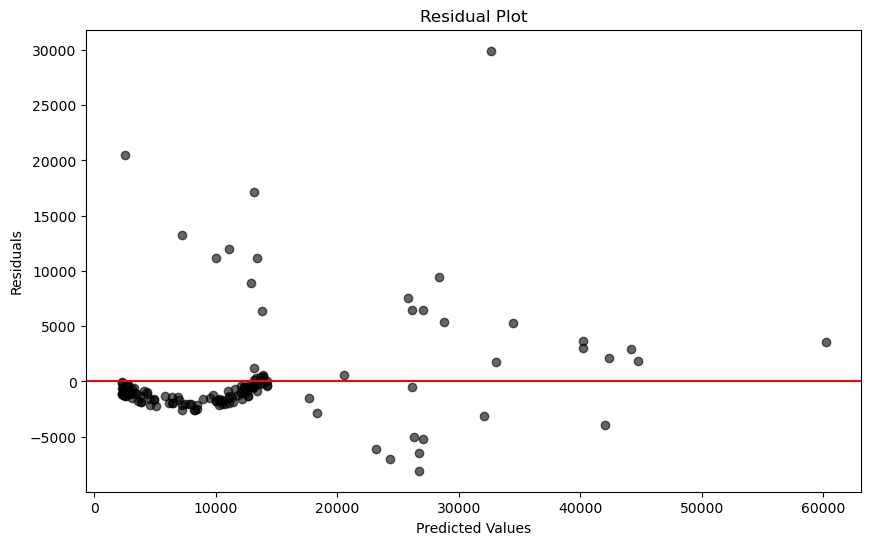

In [64]:
#plot of residuals of final chosen model

#get predicted y
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#get residuals (so y minus predicted y)
residuals = y_test - lr_predicted_1

# Plotting residuals
plt.figure(figsize=(10, 6))
#plots predicted against residuals
plt.scatter(lr_predicted_1, residuals, alpha=0.6, color="black")
#base red line
plt.axhline(y=0, color="red")
#labs
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

**Part Five: Full Exploration**

Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the new data after being fit on the original data.

Make a plot showing the residuals of your final chosen model.

In [ ]:
#Because we are trying to find the best possible model, this will be a case of trial and error between which variables to choose
# The "success" of each model will be measured using R^2

In [ ]:
#From our previous modeling in this lab it seems that smoker is playing a huge role 
# it is unlikely bmi is a good predictor as we saw adding it to our model barely changed anything

In [173]:
#model
# description: charges ~ poly age, poly bmi, smoker, sex age*smoker, bmi*smoker

#train data
X_train = insurance[["age", "bmi", "smoker"]]
y_train = insurance["charges"]

#test data
X_test = insurance_new[["age", "bmi", "smoker"]]
y_test = insurance_new["charges"]

#standardize age and bmi, dummify smoker
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that smoker is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "passthrough"
)

#polynomial to 4th degree
ct_degree = ColumnTransformer(
  [
    ("polynomial_1", PolynomialFeatures(degree = 5), ["standardize__age"]),
    ("polynomial_2", PolynomialFeatures(degree = 2), ["standardize__bmi"]),
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")


#interaction terms
ct_inter = ColumnTransformer(
  [
    ("interaction_age_smoker", PolynomialFeatures(interaction_only = True), ["polynomial_1__standardize__age", "remainder__dummify__smoker_yes"]),
    ("interaction_bmi_smoker", PolynomialFeatures(interaction_only = True), ["polynomial_2__standardize__bmi", "remainder__dummify__smoker_yes"]),
    #("interaction_smoker_sex", PolynomialFeatures(interaction_only = True), ["remainder__dummify__region_southwest", "polynomial__standardize__age"]),
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")


#pipeline
lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("degree", ct_degree),
  ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")




In [150]:
X_1 = ct.fit_transform(X_train)
X_2 = ct_degree.fit_transform(X_1)
X_2

,polynomial__1,polynomial__standardize__age,polynomial__standardize__age^2,remainder__dummify__smoker_no,remainder__dummify__smoker_yes,remainder__standardize__bmi
0,1.0,-1.160028,1.345665,0.0,1.0,-0.469982
1,1.0,-0.303492,0.092108,1.0,0.0,-1.321026
2,1.0,-0.364673,0.132987,1.0,0.0,-0.309439
3,1.0,-0.425855,0.181352,1.0,0.0,-0.823833
4,1.0,1.348398,1.818176,1.0,0.0,-0.807451
...,...,...,...,...,...,...
426,1.0,-0.915303,0.837780,1.0,0.0,0.431027
427,1.0,-1.221209,1.491352,1.0,0.0,0.188573
428,1.0,-1.221209,1.491352,1.0,0.0,0.996205
429,1.0,-1.037666,1.076750,1.0,0.0,-0.814004


In [177]:
#create model
#give X and y
lr_fitted_1 = lr_pipeline_1.fit(X_train, y_train)

# get predictions of new model
#only give X
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#test how well it did
#test MSE
MSE_test = mean_squared_error(y_test, lr_predicted_1)

#test R^2
R_test = r2_score(y_test, lr_predicted_1)

print("mse: ", MSE_test, "r: ", R_test)

mse:  21352429.047707263 r:  0.8622866691502707
mse:  21352429.047707263 r:  0.8622866691502707


**Notes for models**

-adding sex*smoker made model accuracy go down

- adding region*smoker made model accuracy go down

- adding region*age made model accuracy go down

- adding region*bmi made model accuracy go down

- adding region in general seems to make the model go down

- adding sex in general seems to make the model go down

- adding region as well as region*age made model accuracy go down

- adding bmi as a 4th degree polynomail made model accuracy go down

**base model:** 

will be the best model in part four as that has the highest R^2 of every model so far:

charges ~ age, bmi, smoker, age*smoker, bmi*smoker: R^2 ~ .85948

**First improvement of model:**

charges ~ POLYage(degree4), bmi, smoker, age*smoker, bmi*smoker: R^2 ~ .8611

**second improvement of model:**

charges ~ POLYage(degree=4), POLYbmi(degree=2), smoker, age*smoker, bmi*smoker: R^2 ~ .8622


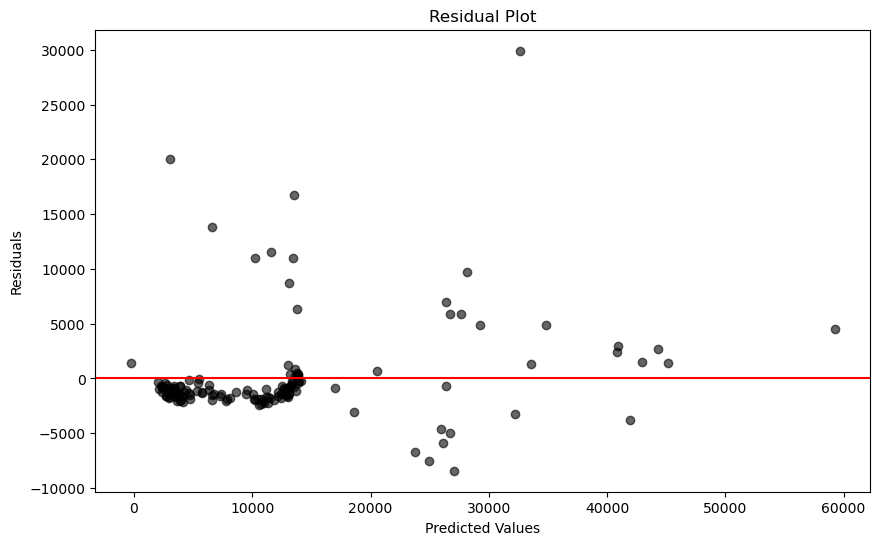

In [178]:
#plot of residuals of final chosen model

#get predicted y
lr_predicted_1 = lr_pipeline_1.predict(X_test)

#get residuals (so y minus predicted y)
residuals = y_test - lr_predicted_1

# Plotting residuals
plt.figure(figsize=(10, 6))
#plots predicted against residuals
plt.scatter(lr_predicted_1, residuals, alpha=0.6, color="black")
#base red line
plt.axhline(y=0, color="red")
#labs
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()